In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from underthesea import word_tokenize, pos_tag, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Import Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Import Evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc

# Import Visualization
import matplotlib.pyplot as plt
import seaborn as sns

Đọc file csv

In [4]:
df_reviews= pd.read_excel('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/Reviews.xlsx')
df_overview_reviews= pd.read_excel('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/Overview_Reviews.xlsx')

Phân loại cảm xúc theo chỉ số Rating <3 negative , == 3 neutral , >3 positive

In [5]:
conditions=[df_reviews["Rating"] < 3,df_reviews["Rating"] == 3,df_reviews["Rating"] > 3]
status=["negative","neutral","positive"]
df_reviews["Sentiment"]=np.select(conditions, status, default="unknown")
df_reviews.head(5)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?,Sentiment
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes,positive
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes,positive
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,Yes,neutral
3,4,Accenture,February 2025,good environment for fresher,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,3,2,2,3,4,4,No,neutral
4,4,Accenture,February 2023,"Môi trường làm việc thoải mái, vui vẻ","- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,4,3,4,4,4,3,Yes,positive


<ipython-input-6-3074617162>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df_reviews, palette='Set1')


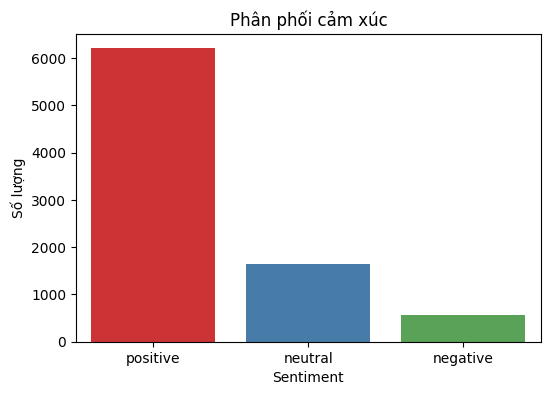

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Phân phối sentiment
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df_reviews, palette='Set1')
plt.title("Phân phối cảm xúc")
plt.xlabel("Sentiment")
plt.ylabel("Số lượng")
plt.show()

=> Qua đồ thị Phân bố cảm xúc cho thấy dữ liệu đang bị bias positive => Cần xử lý mất cân bằng dữ liệu

Kiểm Tra null xem có dữ liệu nào thiếu trên cả 3 cột title , what i liked , Suggestion for Improvement

In [7]:
df_reviews.isnull().sum()

,0
id,0
Company Name,0
Cmt_day,0
Title,0
What I liked,1
Suggestions for improvement,5
Rating,0
Salary & benefits,0
Training & learning,0
Management cares about me,0


Gộp 3 cột Title , What I  liked , Suggestions for improvement thành 1 cột Comment

In [8]:
df_reviews["Comments"] = (df_reviews["Title"].fillna("") + " " +df_reviews["What I liked"].fillna("") + " " +df_reviews["Suggestions for improvement"].fillna(""))
df_reviews.head(5)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?,Sentiment,Comments
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes,positive,"Môi trường thoải mái, ít áp lực, có thể làm vi..."
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes,positive,Công ty trẻ trung năng động Cơ sở vật chất đẹp...
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,Yes,neutral,Môi trường làm việc thoải mái vui vẻ Mội người...
3,4,Accenture,February 2025,good environment for fresher,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,3,2,2,3,4,4,No,neutral,good environment for fresher good env. for fre...
4,4,Accenture,February 2023,"Môi trường làm việc thoải mái, vui vẻ","- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,4,3,4,4,4,3,Yes,positive,"Môi trường làm việc thoải mái, vui vẻ - Văn ph..."


In [9]:
# Bước 3: Load từ điển Anh–Việt từng từ
translation_dict = {}
with open("/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/english-vnmese.txt", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split(None, 1)  # Tách theo dấu cách đầu tiên
        if len(parts) == 2:
            eng, vi = parts
            translation_dict[eng.lower()] = vi.lower()

# Bước 4: Hàm dịch từng từ trong full_text nếu có trong từ điển
def translate_words(text):
    words = text.split()
    translated_words = [translation_dict.get(word.lower(), word) for word in words]
    return " ".join(translated_words)

df_reviews["Comments"] = df_reviews["Comments"].apply(translate_words)

## Tiền xử lý dữ liệu tiếng Việt

In [10]:
# https://underthesea.readthedocs.io/en/v1.1.5/readme.html
# https://github.com/undertheseanlp/underthesea

In [11]:
#LOAD EMOJICON
file = open('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [12]:
def process_text(text, emoji_dict, teen_dict, wrong_lst):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        # ...
        ###### DEL wrong words
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '
    document = new_sentence
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    #...
    return document

In [13]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [14]:
def process_special_word(text):
    # có thể có nhiều từ đặc biệt cần ráp lại với nhau
    new_text = ''
    text_lst = text.split()
    i= 0
    # không, chẳng, chả...
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [15]:
import re
# Hàm để chuẩn hóa các từ có ký tự lặp
def normalize_repeated_characters(text):
    # Thay thế mọi ký tự lặp liên tiếp bằng một ký tự đó
    # Ví dụ: "lònggggg" thành "lòng", "thiệtttt" thành "thiệt"
    return re.sub(r'(.)\1+', r'\1', text)

# Áp dụng hàm chuẩn hóa cho văn bản
# print(normalize_repeated_characters(example))

In [16]:
import regex
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['N','Np','A','AB','V','VB','VY','R']
        # lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [17]:
import regex
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [18]:
import regex
# Hàm chuyển đổi các ký tự có dấu thành không dấu
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split('|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

#Hàm xử lý văn bản bằng tay
def manual_word_handler(text):
    text = text.lower()
    text = covert_unicode(text)
    text = normalize_repeated_characters(text)
    # text = re.sub(r'[^a-zA-ZÀÁẢÃẠÂẤẦẨẪẬĂẮẰẲẴẶÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴĐđ\s]', '', text)
    text = process_special_word(text)
    text = remove_stopword(text, stopwords_lst)
    return text.strip()
# Hàm xử lý văn bản bằng thư viện underthesea
def clean_with_underthesea(text):
    text = str(text).lower()
    # text = re.sub(r'[^a-zA-ZÀÁẢÃẠÂẤẦẨẪẬĂẮẰẲẴẶÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴĐđ\s]', '', text)
    text = word_tokenize(text, format="text")
    text = ' '.join([word for word in text.split() if word not in stopwords_lst])
    return text.strip()


In [19]:
df_reviews["word_handling"] = df_reviews["Comments"].apply(clean_with_underthesea)


In [20]:
df_reviews.head(5)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?,Sentiment,Comments,word_handling
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes,positive,"Môi trường thoải mái, ít áp lực, có thể làm vi...","môi_trường thoải_mái , ít áp_lực , làm_việc hy..."
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes,positive,Công ty trẻ trung năng động Cơ sở vật chất đẹp...,công_ty trẻ trung_năng động_cơ_sở_vật_chất đẹp...
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,Yes,neutral,Môi trường làm việc thoải mái vui vẻ Mội người...,môi_trường làm_việc thoải_mái vui_vẻ mội thân_...
3,4,Accenture,February 2025,good environment for fresher,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,3,2,2,3,4,4,No,neutral,tốt môi trường for người mới ra trường tốt env...,môi_trường trường env . trường học cải_thiện k...
4,4,Accenture,February 2023,"Môi trường làm việc thoải mái, vui vẻ","- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,4,3,4,4,4,3,Yes,positive,"Môi trường làm việc thoải mái, vui vẻ - Văn ph...","môi_trường làm_việc thoải_mái , vui_vẻ - văn_p..."


## Tạo thêm các cột mới dựa trên việc đếm từ/icon positive và negative
- Tạo danh sách các từ positive -> lưu vào file positive_VN.txt (mỗi từ trên 1 dòng)
- Tạo danh sách các từ negative -> lưu vào file negative_VN.txt (mỗi từ trên 1 dòng)
- Tạo danh sách các positve emojis -> lưu vào file positive_emoji.txt (mỗi icon trên 1 dòng)
- Tạo danh sách các negative emojis -> lưu vào file negative_emoji.txt (mỗi icon trên 1 dòng)
- Đọc vào các list tương ứng
- Viết function để đọc 1 chuỗi -> đếm số lượng positive words/ emojis hoặc  negative words/ ememojis, danh sách từ kết quả
- Tạo ra 2 cột mới cho dataframe: negative_count/ positive_count
- ...

In [21]:
# Đọc lại các file vừa lưu thành list
def read_list_from_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f.readlines() if line.strip()]

positive_words = read_list_from_file('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/positive_VN.txt')
negative_words = read_list_from_file('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/negative_VN.txt')
positive_emojis = read_list_from_file('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/positive_emoji.txt')
negative_emojis = read_list_from_file('/content/gdrive/MyDrive/DL07_K304_NguyenThiHoaThang_NguyenNgocHuan/Sentiment analysis/negative_emoji.txt')




In [22]:
# Hàm đếm số lượng từ và emoji cảm xúc trong 1 chuỗi văn bản
def count_sentiment_items(text, words_list, emojis_list):
    text = str(text).lower()
    word_count = sum(1 for word in words_list if word in text)
    emoji_count = sum(text.count(emoji) for emoji in emojis_list)
    return word_count, emoji_count


# Count
df_reviews["Positive_Word_Count"], df_reviews["Positive_Emoji_Count"] = zip(
    *df_reviews["Comments"].apply(lambda x: count_sentiment_items(x, positive_words, positive_emojis))
)

df_reviews["Negative_Word_Count"], df_reviews["Negative_Emoji_Count"] = zip(
    *df_reviews["Comments"].apply(lambda x: count_sentiment_items(x, negative_words, negative_emojis))
)


In [23]:
df_reviews.head(20)


,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?,Sentiment,Comments,word_handling,Positive_Word_Count,Positive_Emoji_Count,Negative_Word_Count,Negative_Emoji_Count
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes,positive,"Môi trường thoải mái, ít áp lực, có thể làm vi...","môi_trường thoải_mái , ít áp_lực , làm_việc hy...",4,0,2,0
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes,positive,Công ty trẻ trung năng động Cơ sở vật chất đẹp...,công_ty trẻ trung_năng động_cơ_sở_vật_chất đẹp...,0,0,1,0
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,Yes,neutral,Môi trường làm việc thoải mái vui vẻ Mội người...,môi_trường làm_việc thoải_mái vui_vẻ mội thân_...,9,0,0,0
3,4,Accenture,February 2025,good environment for fresher,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,3,2,2,3,4,4,No,neutral,tốt môi trường for người mới ra trường tốt env...,môi_trường trường env . trường học cải_thiện k...,4,0,0,0
4,4,Accenture,February 2023,"Môi trường làm việc thoải mái, vui vẻ","- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,4,3,4,4,4,3,Yes,positive,"Môi trường làm việc thoải mái, vui vẻ - Văn ph...","môi_trường làm_việc thoải_mái , vui_vẻ - văn_p...",6,0,1,0
5,4,Accenture,October 2022,"Môi trường làm việc năng động, hiện đại, thân ...",- Được cấp laptop làm việc\n- Môi trường làm v...,Mua thêm bánh kẹo và nước ngọt để phục vụ đời ...,4,4,4,4,5,4,Yes,positive,"Môi trường làm việc năng động, hiện đại, thân ...","môi_trường làm_việc năng_động , hiện_đại , thâ...",6,0,0,0
6,4,Accenture,October 2022,Sếp tốt - Đồng nghiệp xịn- Nhân sự supportive,- Cấp lap mới khi đi làm\n- Có cafe pha máy th...,- Văn phòng rộng hơn tí thì sẽ thoải mái hơn n...,4,4,5,5,5,4,Yes,positive,Sếp tốt - Đồng nghiệp xịn- Nhân sự supportive ...,sếp - đồng_nghiệp xịn - nhân_sự supportive - l...,2,0,0,0
7,4,Accenture,October 2022,Môi trường đa quốc gia xịn xò,- Laptop và các thiết bị khá xịn xò\n- Môi trư...,Số lượng nhân viên tăng dẫn tới văn phòng hơi ...,4,4,4,4,4,2,Yes,positive,Môi trường đa quốc gia xịn xò - máy tính xách ...,môi_trường đa quốc_gia xịn xò - máy_tính_xách_...,2,0,0,0
8,4,Accenture,October 2022,"Sếp tốt, đồng nghiệp rất hòa đồng và hỗ trợ nhau","Sếp rất thân thiện, luôn cười và luôn có cách ...",Công việc và Sếp đều ổn nên không có gì hơn. N...,5,5,5,5,5,5,Yes,positive,"Sếp tốt, đồng nghiệp rất hòa đồng và hỗ trợ nh...","sếp , đồng_nghiệp hòa đồng nhau sếp thân_thiện...",8,0,2,0
9,4,Accenture,October 2022,Great place to work,Dynamic and young work force\nGreat working en...,Up to now all of things so far so good and I t...,5,5,5,5,5,5,Yes,positive,tuyệt quá địa điểm đến công việc linh hoạt và ...,địa_điểm công_việc linh_hoạt young công_việc l...,4,0,1,0


In [24]:
# Chuyển "Recommend" thành số: Yes → 1, No → 0
df_reviews["Recommend_Num"] = df_reviews["Recommend?"].map({"Yes": 1, "No": 0})


In [25]:
df_reviews[["Company Name","Recommend_Num","Sentiment","word_handling","Positive_Word_Count","Positive_Emoji_Count","Negative_Word_Count","Negative_Emoji_Count"]]

,Company Name,Recommend_Num,Sentiment,word_handling,Positive_Word_Count,Positive_Emoji_Count,Negative_Word_Count,Negative_Emoji_Count
0,Accenture,1,positive,"môi_trường thoải_mái , ít áp_lực , làm_việc hy...",4,0,2,0
1,Accenture,1,positive,công_ty trẻ trung_năng động_cơ_sở_vật_chất đẹp...,0,0,1,0
2,Accenture,1,neutral,môi_trường làm_việc thoải_mái vui_vẻ mội thân_...,9,0,0,0
3,Accenture,0,neutral,môi_trường trường env . trường học cải_thiện k...,4,0,0,0
4,Accenture,1,positive,"môi_trường làm_việc thoải_mái , vui_vẻ - văn_p...",6,0,1,0
...,...,...,...,...,...,...,...,...
8412,Zuhlke Engineering Vietnam,1,positive,môi_trường cực_kì văn_hóa : ấn_tượng phỏng_vấn...,5,0,1,0
8413,Zuhlke Engineering Vietnam,1,positive,môi_trường làm_việc cực_kỳ cởi_mở - sếp thoải_...,7,0,1,0
8414,Zuhlke Engineering Vietnam,1,positive,"công_ty , nhân_viên macbook chuyên_nghiệp inte...",8,0,3,0
8415,Zuhlke Engineering Vietnam,1,positive,"địa_điểm leverage skills - environment : , fla...",4,0,0,0


In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Vectorize lại word_handling
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_tfidf = vectorizer.fit_transform(df_reviews["word_handling"])

# Scale cột số bằng MinMaxScaler để đảm bảo không âm
scaler = MinMaxScaler()
X_scale_num = scaler.fit_transform(df_reviews[["Positive_Word_Count", "Negative_Word_Count",
                      "Positive_Emoji_Count", "Negative_Emoji_Count"]])

# Đưa cột nhị phân vào sparse format
x_bin_sparse=csr_matrix(df_reviews[["Recommend_Num"]].values)

# Ghép lại
X = hstack([X_tfidf,csr_matrix(X_scale_num), x_bin_sparse])

# Encode nhãn sentiment
le = LabelEncoder()
y = le.fit_transform(df_reviews["Sentiment"])

In [27]:
# from sklearn.preprocessing import StandardScaler
# from scipy.sparse import hstack, csr_matrix
# # Các đặc trưng số cần scale
# scaled_features = df_reviews[["Positive_Word_Count", "Negative_Word_Count",
#                       "Positive_Emoji_Count", "Negative_Emoji_Count"]]

# # Cột Recommend không scale
# recommend_feature = df_reviews[["Recommend_Num"]]
# # Scale 4 cột đầu
# scaler = StandardScaler()
# scaled_array = scaler.fit_transform(scaled_features)

# # Convert về sparse matrix
# X_scaled_sparse = csr_matrix(scaled_array)

# # Recommend giữ nguyên, cũng convert sparse
# X_recommend_sparse = csr_matrix(recommend_feature.values)

# # Ghép lại toàn bộ
# X_num = hstack([X_scaled_sparse, X_recommend_sparse])
# X = hstack([X_tfidf, X_num])
# y= df_reviews["Sentiment"]

In [28]:
# Chia dữ liệu tập train test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)


In [29]:
# Kết hợp đặc trưng TF-IDF với đặc trưng số học cho 3 mô hình

# Logistic Regression
model_lr = LogisticRegression(max_iter=1000,class_weight='balanced')
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)


# Decision Tree
model_dt = DecisionTreeClassifier(random_state=42,class_weight='balanced')
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

# Random Forest
model_rf = RandomForestClassifier(random_state=42,class_weight='balanced')
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)


# Tổng hợp kết quả
results_df = pd.DataFrame({
    "Logistic Regression": [
        report_lr["accuracy"],
        report_lr["macro avg"]["f1-score"],
        report_lr["macro avg"]["precision"],
        report_lr["macro avg"]["recall"]
    ],
    "Random Forest": [
        report_rf["accuracy"],
        report_rf["macro avg"]["f1-score"],
        report_rf["macro avg"]["precision"],
        report_rf["macro avg"]["recall"]
    ],
    "Decision Tree": [
        report_dt["accuracy"],
        report_dt["macro avg"]["f1-score"],
        report_dt["macro avg"]["precision"],
        report_dt["macro avg"]["recall"]
    ]
}, index=["Accuracy", "F1-score", "Precision", "Recall"])

In [33]:
results_df

,Logistic Regression,Random Forest,Decision Tree
Accuracy,0.771378,0.760689,0.706057
F1-score,0.663929,0.458523,0.565423
Precision,0.632455,0.655675,0.556518
Recall,0.715826,0.434046,0.576232


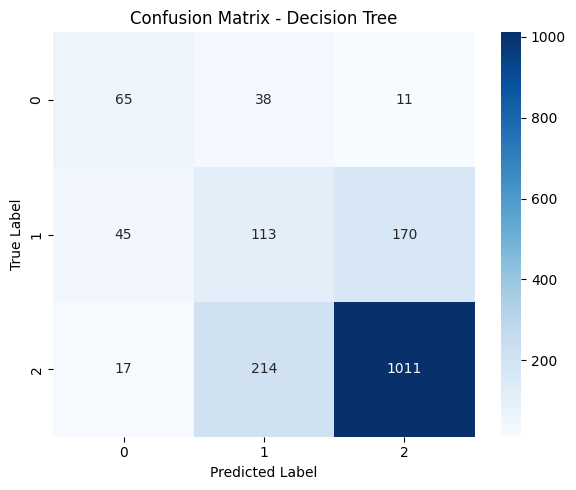

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix cho mô hình Decision Tree
labels = sorted(np.unique(y))
cm = confusion_matrix(y_test, y_pred_dt, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Decision Tree")
plt.tight_layout()
plt.show()

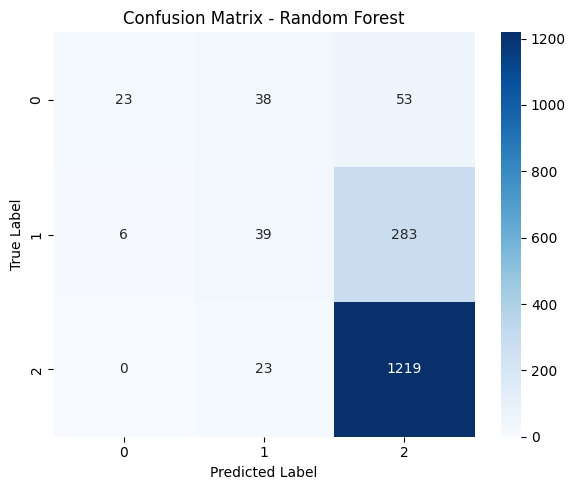

In [31]:
# Confusion matrix cho mô hình Random Forest
labels = sorted(np.unique(y))
cm = confusion_matrix(y_test, y_pred_rf, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

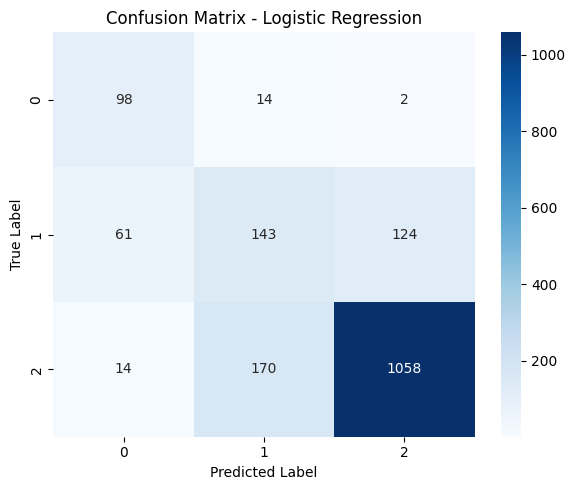

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix cho mô hình Navie Bayes
labels = sorted(np.unique(y))
cm = confusion_matrix(y_test, y_pred_lr, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

=> Model Logistic Regression cho kết quả tốt nhất . Cả accuracy và f1 score đều tối ưu khi so sánh giữa các mô hình khác
